In [1]:
from importlist import *

In [2]:
# Example usage:
savefile = "data.json"
points_count = 100
to_plot = False
no_centres = 3
noise = 0.1
dataset_types = ["circles", "moons", "blobs"]
dataset_type = dataset_types[2]

In [3]:
# Example usage:
points = generate_dataset(
    dataset_type="circles", points_count=100, noise=0.1, no_centres=3, to_plot=False
)
mst_builder = MST(points)

# Measure runtime for K-MSTree
start_time = tm.time()
mst_weight, edge_count, final_graph = mst_builder.apply_mst(
    algorithm="kmistree", to_plot=False
)
end_time = tm.time()
kmistree_runtime = end_time - start_time
print(
    f"K-MSTree: Total Weight: {mst_weight}, Edge Count: {edge_count}, Runtime: {kmistree_runtime:.4f} seconds"
)

# Measure runtime for K-MST
start_time = tm.time()
mst_weight, edge_count, final_graph = mst_builder.apply_mst(
    algorithm="kmist", to_plot=False
)
end_time = tm.time()
kmist_runtime = end_time - start_time
print(
    f"K-MST: Total Weight: {mst_weight}, Edge Count: {edge_count}, Runtime: {kmist_runtime:.4f} seconds"
)

# Measure runtime for Prim's MST
start_time = tm.time()
prim_weight, edge_count, final_graph = mst_builder.apply_mst(
    algorithm="prim", to_plot=False
)
end_time = tm.time()
prim_runtime = end_time - start_time
print(
    f"Prim's MST: Total Weight: {prim_weight}, Edge Count: {edge_count}, Runtime: {prim_runtime:.4f} seconds"
)

# Measure runtime for FMST
start_time = tm.time()
mst_weight, edge_count, final_graph = mst_builder.apply_mst(
    algorithm="fmst", to_plot=False
)
end_time = tm.time()
fmst_runtime = end_time - start_time
print(
    f"FMST: Total Weight: {mst_weight}, Edge Count: {edge_count}, Runtime: {fmst_runtime:.4f} seconds"
)

K-MSTree: Total Weight: 13.91, Edge Count: 238, Runtime: 0.0069 seconds
K-MST: Total Weight: 13.93, Edge Count: 260, Runtime: 0.0106 seconds
Prim's MST: Total Weight: 13.89, Edge Count: 10000, Runtime: 0.0246 seconds
FMST: Total Weight: 14.289502585521644, Edge Count: 526, Runtime: 0.1162 seconds


/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


After processing cluster 0, number of edges: 5
Total weight of edges: 1.0728175351364349
After processing cluster 1, number of edges: 12
Total weight of edges: 2.196338519710058
After processing cluster 2, number of edges: 19
Total weight of edges: 3.266093147627287
After processing cluster 3, number of edges: 32
Total weight of edges: 4.930802761866174
After processing cluster 4, number of edges: 43
Total weight of edges: 6.619540539026323
After processing cluster 5, number of edges: 56
Total weight of edges: 7.8885497871084524
After processing cluster 6, number of edges: 62
Total weight of edges: 8.842807031508226
After processing cluster 7, number of edges: 72
Total weight of edges: 10.160019362002163
After processing cluster 8, number of edges: 83
Total weight of edges: 11.516638509273633
After processing cluster 9, number of edges: 90
Total weight of edges: 12.48898959707979
After adding cluster points and centroids, number of edges: 90
Total weight of edges: 12.48898959707979
Aft

/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


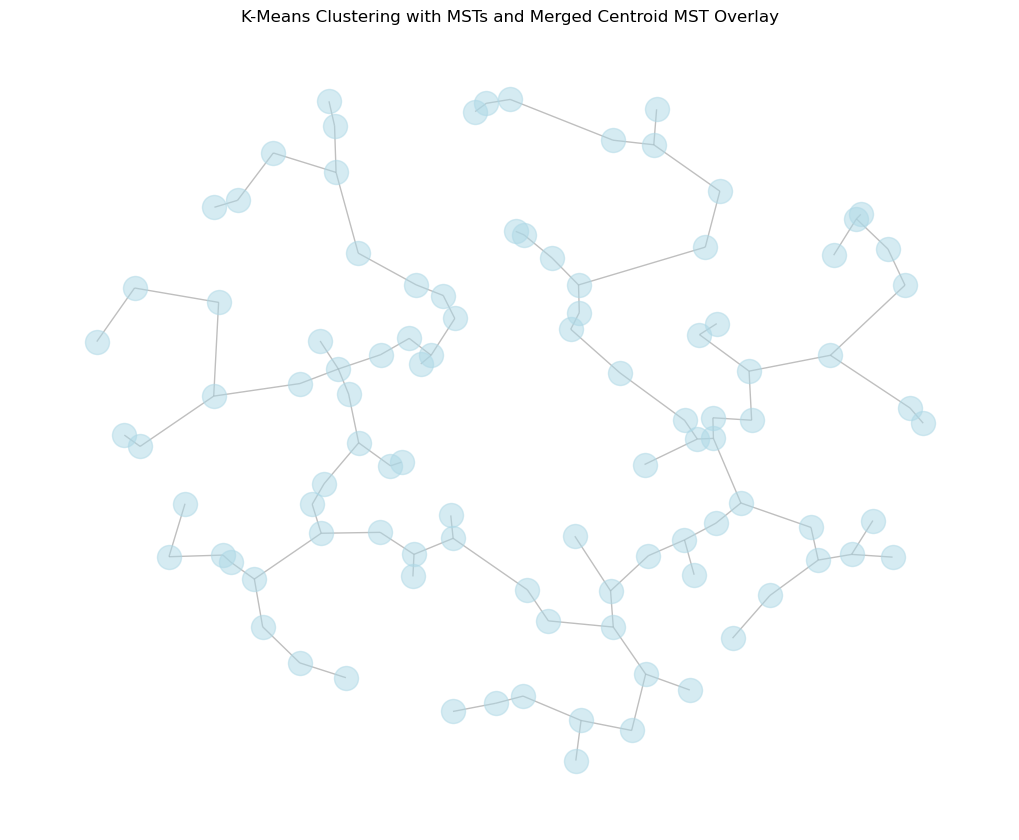

In [4]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import networkx as nx


def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))


def prim_mst(points):
    n = len(points)
    if n == 0:
        return []

    # Initialize arrays for Prim's algorithm
    in_mst = [False] * n
    min_edge = [float("inf")] * n
    parent = [-1] * n
    min_edge[0] = 0

    mst_edges = []

    for _ in range(n):
        # Find the minimum edge
        u = -1
        for i in range(n):
            if not in_mst[i] and (u == -1 or min_edge[i] < min_edge[u]):
                u = i

        in_mst[u] = True

        # Add the edge to the MST
        if parent[u] != -1:
            mst_edges.append((u, parent[u]))

        # Update the minimum edge array
        for v in range(n):
            if not in_mst[v] and euclidean_distance(points[u], points[v]) < min_edge[v]:
                min_edge[v] = euclidean_distance(points[u], points[v])
                parent[v] = u

    return mst_edges


def merge_comps(core1, core2, core_points_map, G):
    """
    Merge two components in the graph.

    Parameters:
    core1 (tuple): The first core point.
    core2 (tuple): The second core point.
    core_points_map (dict): Map of core points to their components.
    G (dict): The graph to merge components in.
    """
    pivot1 = min(
        core_points_map[core1],
        key=lambda node: euclidean_distance(node, core2),
    )
    pivot2 = min(
        core_points_map[core2],
        key=lambda node: euclidean_distance(node, pivot1),
    )
    G[pivot1].append((pivot2, euclidean_distance(pivot1, pivot2)))
    G[pivot2].append((pivot1, euclidean_distance(pivot1, pivot2)))
    print(f"Merging {core1} and {core2} with pivot {pivot1} and {pivot2}")


def calculate_total_weight(G):
    total_weight = sum(weight for edges in G.values() for _, weight in edges) / 2
    return total_weight


# Assuming points is a list of coordinates, e.g., [(x1, y1), (x2, y2), ...]
# Uncomment the next line and replace with actual points
# points = [...]

n = len(points)
k = int(n**0.5)

# K-means clustering
kmeans = KMeans(n_clusters=k).fit(points)
labels = kmeans.labels_
centers = kmeans.cluster_centers_.tolist()

# Splitting the points cluster-wise
clusters = [[] for _ in range(k)]
for point, label in zip(points, labels):
    clusters[label].append(tuple(point))  # Convert points to tuples

# Finding centroids of each cluster
centroids = []
for cluster in clusters:
    cluster_points = np.array(cluster)
    centroid = tuple(cluster_points.mean(axis=0))
    centroids.append(centroid)

# Initialize the main graph
G = {point: [] for cluster in clusters for point in cluster}

for cluster_index, cluster in enumerate(clusters):
    if len(cluster) > 1:  # MST is not defined for a single point
        mst_edges = prim_mst(cluster)
        for u, v in mst_edges:
            G[cluster[u]].append(
                (cluster[v], euclidean_distance(cluster[u], cluster[v]))
            )
            G[cluster[v]].append(
                (cluster[u], euclidean_distance(cluster[u], cluster[v]))
            )

    # Print number of edges and total weight after each cluster's MST
    print(
        f"After processing cluster {cluster_index}, number of edges: {sum(len(edges) for edges in G.values()) // 2}"
    )
    print(f"Total weight of edges: {calculate_total_weight(G)}")

# Print number of edges and total weight after adding cluster points and centroids
print(
    f"After adding cluster points and centroids, number of edges: {sum(len(edges) for edges in G.values()) // 2}"
)
print(f"Total weight of edges: {calculate_total_weight(G)}")

# Create MST of centroids
centroid_points = np.array(centroids)
centroid_edges = prim_mst(centroid_points)

# Print number of edges and total weight after creating MST of centroids
print(f"After creating MST of centroids, number of edges: {len(centroid_edges)}")
print(
    f"Total weight of edges in centroid MST: {sum(euclidean_distance(centroid_points[u], centroid_points[v]) for u, v in centroid_edges)}"
)

# Mapping core points to their components
core_points_map = {}
for component in clusters:
    if len(component) > 0:
        centroid = tuple(np.mean([node for node in component], axis=0))
        closest_point = min(
            component, key=lambda node: euclidean_distance(node, centroid)
        )
        core_points_map[closest_point] = component

# Ensure all centroids are mapped to core points
for centroid in centroids:
    if centroid not in core_points_map:
        closest_point = min(
            G.keys(), key=lambda node: euclidean_distance(node, centroid)
        )
        core_points_map[centroid] = core_points_map[closest_point]

# Convert centroid_points to tuples for hashing
centroid_points = [tuple(point) for point in centroid_points]

for edge in centroid_edges:
    merge_comps(centroid_points[edge[0]], centroid_points[edge[1]], core_points_map, G)
    # Print number of edges and total weight after each merge
    print(
        f"After merging {centroid_points[edge[0]]} and {centroid_points[edge[1]]}, number of edges: {sum(len(edges) for edges in G.values()) // 2}"
    )
    print(f"Total weight of edges: {calculate_total_weight(G)}")

# Print final number of nodes and edges
print(f"Final number of nodes in the graph: {len(G)}")
print(
    f"Final number of edges in the graph: {sum(len(edges) for edges in G.values()) // 2}"
)
print(f"Final total weight of edges: {calculate_total_weight(G)}")

# Option to plot the graph using networkx
plot_graph = True

if plot_graph:
    nx_graph = nx.Graph()
    for node, edges in G.items():
        for neighbor, weight in edges:
            nx_graph.add_edge(node, neighbor, weight=weight)

    pos = {node: node for node in nx_graph.nodes()}
    plt.figure(figsize=(10, 8))
    nx.draw(
        nx_graph,
        pos,
        with_labels=False,
        node_color="lightblue",
        edge_color="gray",
        alpha=0.5,
    )
    plt.title("K-Means Clustering with MSTs and Merged Centroid MST Overlay")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.show()

/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Time taken by fast MST: 0.05172443389892578
Total weight of the MST: 13.973464744672086 Number of edges: 98 Number of points: 100


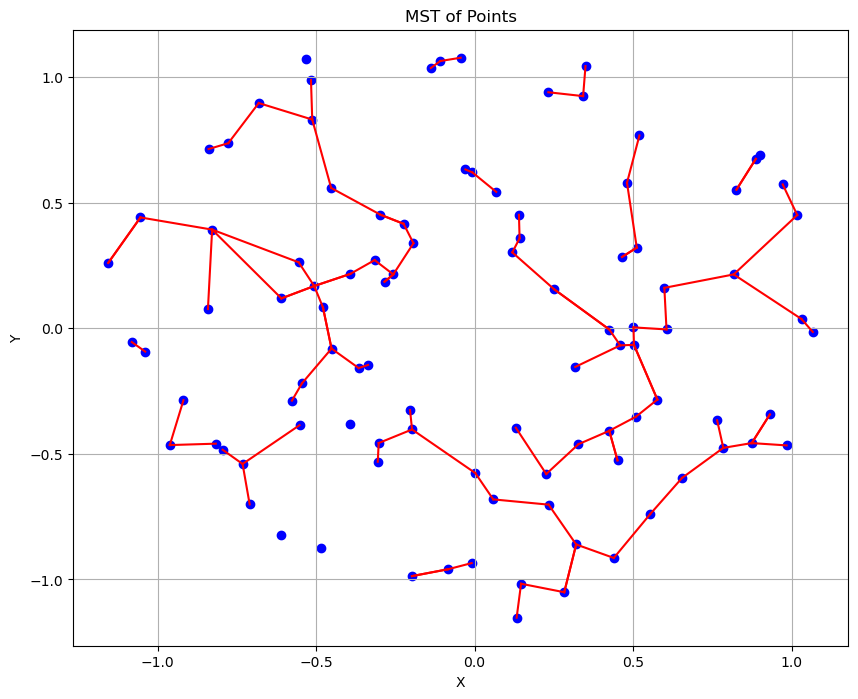

In [5]:
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree


# Define the functions and the main process as given
def euclidean_distance(p1, p2):
    return sum((a - b) ** 2 for a, b in zip(p1, p2)) ** 0.5


def detect_connecting_edge(cluster1, cluster2):
    center1 = [sum(x) / len(cluster1) for x in zip(*cluster1)]
    center2 = [sum(x) / len(cluster2) for x in zip(*cluster2)]

    min_dist1 = float("inf")
    min_point1 = None
    for point in cluster1:
        dist = euclidean_distance(point, center2)
        if dist < min_dist1:
            min_dist1 = dist
            min_point1 = point

    min_dist2 = float("inf")
    min_point2 = None
    for point in cluster2:
        dist = euclidean_distance(point, center1)
        if dist < min_dist2:
            min_dist2 = dist
            min_point2 = point

    return min_point1, min_point2


def fast_mst(points):
    n = len(points)
    k = int(n**0.5)

    # Divide-and-conquer stage
    kmeans = KMeans(n_clusters=k).fit(points)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.tolist()

    mst_edges = []
    total_weight = 0

    for i in range(k):
        cluster_points = [points[j] for j in range(n) if labels[j] == i]
        pairwise_distances = squareform(pdist(cluster_points))
        mst = minimum_spanning_tree(pairwise_distances).toarray().tolist()
        edges = [
            (u, v)
            for u in range(len(cluster_points))
            for v in range(u + 1, len(cluster_points))
            if mst[u][v] > 0
        ]
        for u, v in edges:
            weight = euclidean_distance(cluster_points[u], cluster_points[v])
            mst_edges.append((cluster_points[u], cluster_points[v]))
            total_weight += weight

    pairwise_distances_centers = squareform(pdist(centers))
    mst_centers = minimum_spanning_tree(pairwise_distances_centers).toarray().tolist()
    center_edges = [
        (i, j) for i in range(k) for j in range(i + 1, k) if mst_centers[i][j] > 0
    ]

    # Refinement stage
    midpoints = []
    for i, j in center_edges:
        cluster1 = [points[m] for m in range(n) if labels[m] == i]
        cluster2 = [points[m] for m in range(n) if labels[m] == j]
        u, v = detect_connecting_edge(cluster1, cluster2)
        mst_edges.append((u, v))
        midpoint = [(a + b) / 2 for a, b in zip(u, v)]
        midpoints.append(midpoint)
        weight = euclidean_distance(u, v)
        total_weight += weight

    kmeans_refine = KMeans(n_clusters=len(midpoints), init=midpoints, n_init=1).fit(
        points
    )
    labels_refine = kmeans_refine.labels_

    for i in range(len(midpoints)):
        cluster_points = [points[j] for j in range(n) if labels_refine[j] == i]
        pairwise_distances = squareform(pdist(cluster_points))
        mst = minimum_spanning_tree(pairwise_distances).toarray().tolist()
        edges = [
            (u, v)
            for u in range(len(cluster_points))
            for v in range(u + 1, len(cluster_points))
            if mst[u][v] > 0
        ]
        for u, v in edges:
            weight = euclidean_distance(cluster_points[u], cluster_points[v])
            mst_edges.append((cluster_points[u], cluster_points[v]))
            total_weight += weight

    return mst_edges, total_weight


# Example points (you can replace this with your own data)
# points = [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]]

# Measure time and execute fast_mst
fmst_start_time = time.time()
mst_edges, fmst_weight = fast_mst(points)
fmst_end_time = time.time()
fmst_edgecount = len(mst_edges)
fmst_elapsed_time = fmst_end_time - fmst_start_time

print("Time taken by fast MST:", fmst_elapsed_time)
print(
    "Total weight of the MST:",
    fmst_weight,
    "Number of edges:",
    fmst_edgecount,
    "Number of points:",
    len(points),
)


# Plot the graph
def plot_graph(points, mst_edges):
    plt.figure(figsize=(10, 8))
    x, y = zip(*points)
    plt.scatter(x, y, color="blue")

    for edge in mst_edges:
        p1, p2 = edge
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color="red")

    plt.title("MST of Points")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


plot_graph(points, mst_edges)

/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/voy/.local/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


After processing cluster 0, number of edges: 12
After processing cluster 1, number of edges: 24
After processing cluster 2, number of edges: 34
After processing cluster 3, number of edges: 46
After processing cluster 4, number of edges: 52
After processing cluster 5, number of edges: 63
After processing cluster 6, number of edges: 68
After processing cluster 7, number of edges: 75
After processing cluster 8, number of edges: 81
After processing cluster 9, number of edges: 90
After adding cluster points and centroids, number of edges: 90
After creating MST of centroids, number of edges: 9
Merging (-0.11789582351280047, 0.38507803369359633) and (-0.6159270568068367, 0.8284600868354096) with pivot (-0.2973023049892942, 0.45247709951540904) and (-0.45275597493826714, 0.559080663552446)
After merging (-0.11789582351280047, 0.38507803369359633) and (-0.6159270568068367, 0.8284600868354096), number of edges: 91
Merging (-0.11789582351280047, 0.38507803369359633) and (0.1055814612132307, 1.014

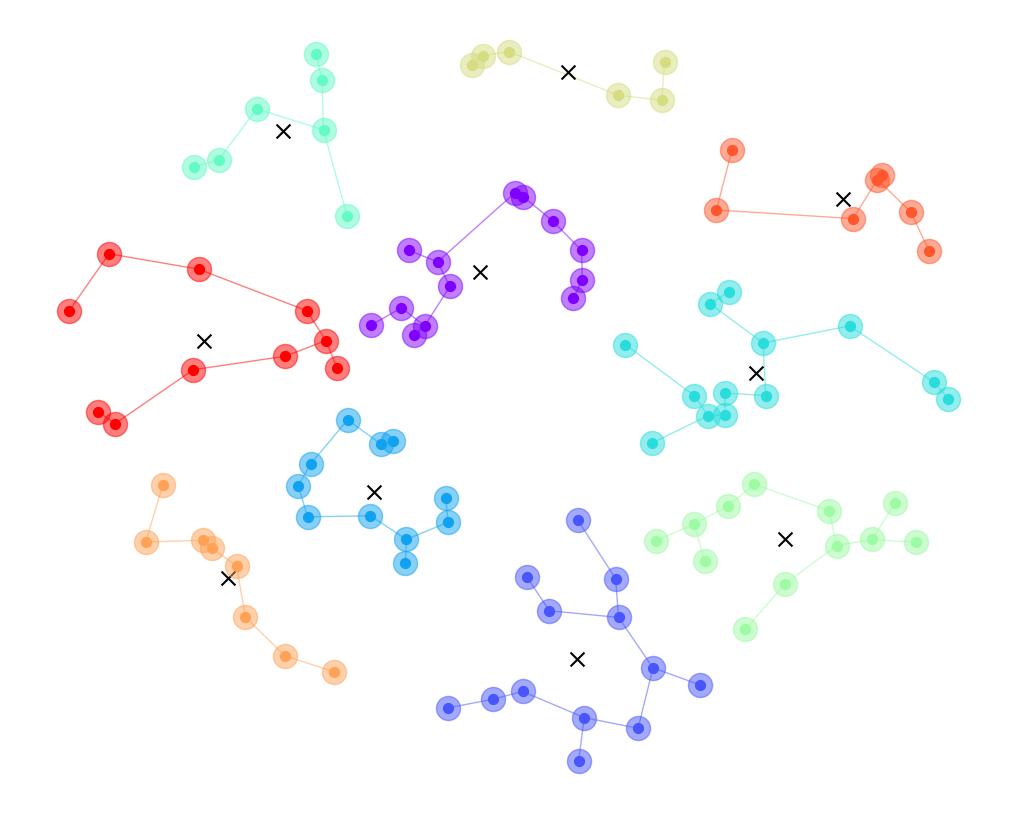

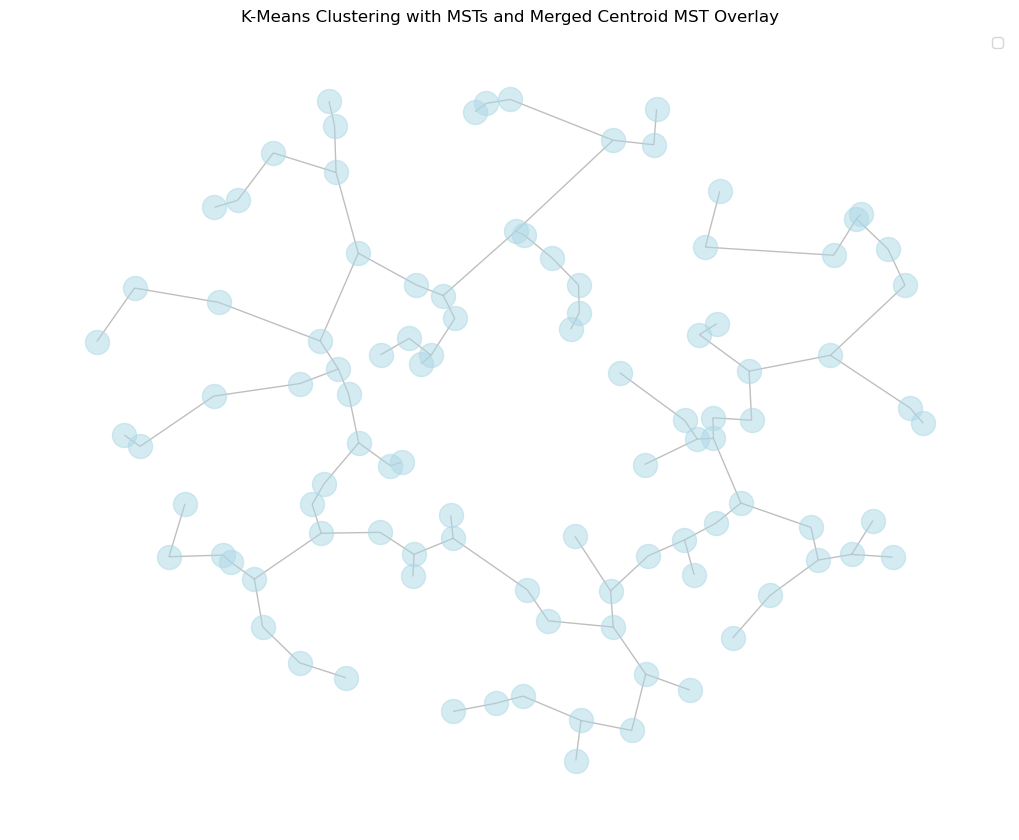

Centroid of Cluster 0: (-0.11789582351280047, 0.38507803369359633)
Centroid of Cluster 1: (0.12916958594599268, -0.8315663275437994)
Centroid of Cluster 2: (-0.38469760025895144, -0.30684676081644136)
Centroid of Cluster 3: (0.5808261409460849, 0.06674767073045687)
Centroid of Cluster 4: (-0.6159270568068367, 0.8284600868354096)
Centroid of Cluster 5: (0.6529667690564623, -0.45607534972805763)
Centroid of Cluster 6: (0.1055814612132307, 1.014675099618615)
Centroid of Cluster 7: (-0.7538033823609652, -0.5787674609939721)
Centroid of Cluster 8: (0.8002803237338999, 0.6127011613677631)
Centroid of Cluster 9: (-0.8151649648702634, 0.16598904764944916)
Final number of nodes in the graph: 100
Final number of edges in the graph: 99


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform


def euclidean_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))


def merge_comps(core1, core2, core_points_map, G):
    """
    Merge two components in the graph.

    Parameters:
    core1 (tuple): The first core point.
    core2 (tuple): The second core point.
    core_points_map (dict): Map of core points to their components.
    G (networkx.Graph): The graph to merge components in.
    """
    pivot1 = min(
        core_points_map[core1],
        key=lambda node: euclidean_distance(node, core2),
    )
    pivot2 = min(
        core_points_map[core2],
        key=lambda node: euclidean_distance(node, pivot1),
    )
    G.add_edge(pivot1, pivot2, weight=euclidean_distance(pivot1, pivot2))
    print(f"Merging {core1} and {core2} with pivot {pivot1} and {pivot2}")


# Assuming points is a list of coordinates, e.g., [(x1, y1), (x2, y2), ...]
# Uncomment the next line and replace with actual points
# points = [...]

n = len(points)
k = int(n**0.5)

# K-means clustering
kmeans = KMeans(n_clusters=k).fit(points)
labels = kmeans.labels_
centers = kmeans.cluster_centers_.tolist()

# Splitting the points cluster-wise
clusters = [[] for _ in range(k)]
for point, label in zip(points, labels):
    clusters[label].append(tuple(point))  # Convert points to tuples

# Finding centroids of each cluster
centroids = []
for cluster in clusters:
    cluster_points = np.array(cluster)
    centroid = tuple(cluster_points.mean(axis=0))
    centroids.append(centroid)

# Plotting all clusters and their MSTs on a single graph
plt.figure(figsize=(10, 8))
colors = plt.cm.rainbow(np.linspace(0, 1, k))

G = nx.Graph()

for cluster_index, (cluster, color) in enumerate(zip(clusters, colors)):
    if len(cluster) > 1:  # MST is not defined for a single point
        cluster_points = np.array(cluster)
        distances = pdist(cluster_points)
        dist_matrix = squareform(distances)

        cluster_graph = nx.Graph()
        for i in range(len(cluster_points)):
            for j in range(i + 1, len(cluster_points)):
                cluster_graph.add_edge(
                    tuple(cluster_points[i]),
                    tuple(cluster_points[j]),
                    weight=dist_matrix[i, j],
                )

        mst = nx.minimum_spanning_tree(cluster_graph)
        G.add_edges_from(mst.edges(data=True))
        pos = {tuple(i): (i[0], i[1]) for i in cluster_points}
        nx.draw(
            mst, pos, with_labels=False, node_color=color, edge_color=color, alpha=0.5
        )

    # Print number of edges after each cluster's MST
    print(
        f"After processing cluster {cluster_index}, number of edges: {G.number_of_edges()}"
    )

# Adding cluster points and centroids to the plot
for cluster_index, (cluster, color) in enumerate(zip(clusters, colors)):
    cluster_points = np.array(cluster)
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        color=color,
        label=f"Cluster {cluster_index}",
        s=50,
    )
    centroid = centroids[cluster_index]
    plt.scatter(
        centroid[0],
        centroid[1],
        color="black",
        marker="x",
        s=100,
        label=f"Centroid {cluster_index}",
    )

# Print number of edges after adding cluster points and centroids
print(
    f"After adding cluster points and centroids, number of edges: {G.number_of_edges()}"
)

# Create MST of centroids
centroid_points = np.array(centroids)
centroid_distances = pdist(centroid_points)
centroid_dist_matrix = squareform(centroid_distances)

centroid_graph = nx.Graph()
for i in range(len(centroid_points)):
    for j in range(i + 1, len(centroid_points)):
        centroid_graph.add_edge(
            tuple(centroid_points[i]),
            tuple(centroid_points[j]),
            weight=centroid_dist_matrix[i, j],
        )

centroid_mst = nx.minimum_spanning_tree(centroid_graph)

# Print number of edges after creating MST of centroids
print(
    f"After creating MST of centroids, number of edges: {centroid_mst.number_of_edges()}"
)

# Mapping core points to their components
core_points_map = {}
for component in nx.connected_components(G):
    centroid = tuple(np.mean([node for node in component], axis=0))
    closest_point = min(component, key=lambda node: euclidean_distance(node, centroid))
    core_points_map[closest_point] = component

# Ensure all centroids are mapped to core points
for centroid in centroids:
    if centroid not in core_points_map:
        closest_point = min(
            G.nodes, key=lambda node: euclidean_distance(node, centroid)
        )
        core_points_map[centroid] = core_points_map[closest_point]

for edge in centroid_mst.edges:
    merge_comps(edge[0], edge[1], core_points_map, G)
    # Print number of edges after each merge
    print(
        f"After merging {edge[0]} and {edge[1]}, number of edges: {G.number_of_edges()}"
    )

# Draw the merged graph
plt.figure(figsize=(10, 8))
pos = {i: (i[0], i[1]) for i in G.nodes}
nx.draw(G, pos, with_labels=False, node_color="lightblue", edge_color="gray", alpha=0.5)
plt.title("K-Means Clustering with MSTs and Merged Centroid MST Overlay")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.legend()
plt.show()

# Print centroids
for i, centroid in enumerate(centroids):
    print(f"Centroid of Cluster {i}: {centroid}")

# Print final number of nodes and edges
print(f"Final number of nodes in the graph: {G.number_of_nodes()}")
print(f"Final number of edges in the graph: {G.number_of_edges()}")

In [7]:
print("KMeans labels:", labels , centers)

KMeans labels: [9 9 9 9 7 7 9 4 9 7 7 4 7 7 4 7 9 2 9 2 2 4 4 4 9 7 9 4 2 2 0 2 2 0 2 2 0
 0 0 0 2 1 2 0 6 6 1 6 0 1 0 1 1 0 0 1 1 0 0 1 1 6 1 3 1 3 1 5 6 6 5 3 1 5
 3 3 8 3 3 5 3 8 5 5 3 3 5 5 5 3 8 5 8 8 5 8 5 8 3 3] [[-0.1178958235128005, 0.3850780336935965], [0.12916958594599268, -0.8315663275437993], [-0.38469760025895144, -0.30684676081644136], [0.580826140946085, 0.06674767073045688], [-0.6159270568068367, 0.8284600868354097], [0.6529667690564623, -0.4560753497280575], [0.10558146121323068, 1.0146750996186151], [-0.7538033823609652, -0.5787674609939721], [0.8002803237338998, 0.6127011613677631], [-0.8151649648702634, 0.1659890476494492]]
